## Project • F10 • Math 189 • Sp 2024
### Due Date: Sun, June 9

> Memebers: $\color{red}{\text{Max Yuen Sum Wong, Max Wild, Qianli (Eric) Wu}}$
> 
> PIDs: $\color{red}{\text{A17637268, A17014151, A16811446}}$
>
> 

# Analysis on Market Trends of Video Games

In [ ]:
import numpy as np
import scipy.stats as stats
from scipy.stats import chi2_contingency

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
import seaborn as sns

import plotly
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
# pio.renderers.default='notebook'

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.tsa.stattools import acf

from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.linear_model import Lasso, Ridge
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

import patsy

In [2]:
# Copied from @Max.W 

consoles = pd.read_csv('consoles.csv')
games = pd.read_csv('games.csv')

name_dict = {
    'Wii': 'Wii',
    'NES': 'NES/Famicom',
    'GB': 'Game Boy',
    'DS': 'Nintendo DS',
    'X360': 'Xbox 360',
    'PS3': 'PlayStation 3',
    'PS2': 'PlayStation 2',
    'SNES': 'SNES/Super Famicom',
    'GBA': 'Game Boy Advance',
    '3DS': 'Nintendo 3DS',
    'PS4': 'PlayStation 4',
    'N64': 'Nintendo 64',
    'PS': 'PlayStation',
    'XB': 'Xbox',
    'PC': 'PC',
    '2600': 'Atari 2600',
    'PSP': 'PlayStation Portable',
    'XOne': 'Xbox One',
    'GC': 'GameCube',
    'WiiU': 'Wii U',
    'GEN': 'Sega Genesis/Mega Drive',
    'DC': 'Dreamcast',
    'PSV': 'PlayStation Vita',
    'SAT': 'Sega Saturn',
    'SCD': 'Sega CD',
    'WS': 'WonderSwan',
    'NG': 'N-Gage',
    'TG16': 'PC Engine/TurboGrafx-16',
    '3DO': '3DO',
    'GG': 'Sega Game Gear',
    'PCFX': 'PC-FX'
}
games['Platform'] = games['Platform'].map(name_dict)

merged_df = games.merge(consoles, left_on='Platform', right_on='Console Name', how='left')
merged_df = merged_df.drop(columns=['Remarks', 'Rank', 'Console Name'])
merged_df = merged_df.rename(columns={
    'Name': 'Game_Name',
    'Units sold (million)': 'Units_sold_million', 
    'Released Year': 'Released_Year',
    'Discontinuation Year': 'Discontinuation_Year'})

games_sales = merged_df.dropna().copy()

## **Overview**

### **Statement of the Problem**

In this project, we investigate the factors that contribute to the success of video games in terms of global sales. Specifically, we aim to understand the relationship between game attributes such as genre, platform, publisher, and release year, and their impact on sales performance. Additionally, we explore the regional sales differences and the characteristics of top-selling games within each genre.

### **Relevance of the Problem**

Understanding the factors that influence video game sales is crucial for developers, publishers, and marketers in the gaming industry. Identifying the key elements that lead to commercial success can help stakeholders make informed decisions about game development, marketing strategies, and resource allocation. This investigation is inspired by the rapid growth of the gaming industry and the need to discern patterns that drive consumer preferences and market trends.

### **Data Sources**

We obtained our data from Kaggle, focusing on two primary datasets:

1. **Video Game Sales Analysis and Visualization**
   - **Source**: [Video Game Sales Analysis and Visualization](https://www.kaggle.com/code/snanilim/video-games-sales-analysis-and-visualization/input)
   - **Description**: This dataset includes information on video game sales from the 1980s to the 2010s. It provides details on each game's genre, publisher, platform, and sales across various regions (North America, Europe, Japan, and others). The columns in this dataset are: Rank, Name, Platform, Year, Genre, Publisher, NA_Sales, EU_Sales, JP_Sales, Other_Sales, and Global_Sales.
   - **Relevance**: This dataset offers a comprehensive overview of video game sales, allowing us to explore relationships such as regional differences, genre preferences, and platform popularity.

2. **Best-Selling Gaming Consoles Dataset**
   - **Source**: [Best-Selling Gaming Consoles Dataset](https://www.kaggle.com/datasets/tayyarhussain/best-selling-game-consoles-of-all-time)
   - **Description**: This dataset provides information on the popularity of different gaming consoles over time. It includes columns such as Console Name, Type, Company, Released Year, Discontinuation Year, Unit Sold (million), and Remarks.
   - **Relevance**: This dataset enables us to analyze trends in the gaming industry and compare the performance of different manufacturers. It can be merged with the video game sales dataset to investigate the relationship between console popularity and game sales.

### **Description of the Data**

The primary dataset on video game sales consists of the following columns:
- **Rank**: The ranking of the game based on global sales.
- **Name**: The name of the video game.
- **Platform**: The gaming platform on which the game was released (e.g., PS4, Xbox One, Wii).
- **Year**: The year the game was released.
- **Genre**: The genre of the game (e.g., Action, Adventure, Sports).
- **Publisher**: The company that published the game.
- **NA_Sales**: Sales in North America (in millions of units).
- **EU_Sales**: Sales in Europe (in millions of units).
- **JP_Sales**: Sales in Japan (in millions of units).
- **Other_Sales**: Sales in other regions (in millions of units).
- **Global_Sales**: Total global sales (in millions of units).

The secondary dataset on best-selling gaming consoles includes:
- **Console Name**: The name of the gaming console.
- **Type**: The type of console (e.g., home console, handheld).
- **Company**: The company that manufactured the console.
- **Released Year**: The year the console was released.
- **Discontinuation Year**: The year the console was discontinued.
- **Unit Sold**: The number of units sold (in millions).
- **Remarks**: Additional remarks about the console.

By combining insights from these two datasets, we aim to provide a detailed analysis of the factors influencing video game sales and the characteristics of top-selling games and consoles. This will help identify trends and patterns that are critical for success in the gaming market.

In [3]:
games_sales

,Game_Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Type,Company,Released_Year,Discontinuation_Year,Units_sold_million
0,Wii Sports,Wii,2006.0,Sports,Nintendo,41.49,29.02,3.77,8.46,82.74,Home,Nintendo,2006.0,2013.0,101.63
1,Super Mario Bros.,NES/Famicom,1985.0,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24,Home,Nintendo,1983.0,2003.0,61.91
2,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15.85,12.88,3.79,3.31,35.82,Home,Nintendo,2006.0,2013.0,101.63
3,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15.75,11.01,3.28,2.96,33.00,Home,Nintendo,2006.0,2013.0,101.63
4,Pokemon Red/Pokemon Blue,Game Boy,1996.0,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37,Handheld,Nintendo,1989.0,2003.0,64.42
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16593,Woody Woodpecker in Crazy Castle 5,Game Boy Advance,2002.0,Platform,Kemco,0.01,0.00,0.00,0.00,0.01,Handheld,Nintendo,2001.0,2010.0,81.51
16594,Men in Black II: Alien Escape,GameCube,2003.0,Shooter,Infogrames,0.01,0.00,0.00,0.00,0.01,Home,Nintendo,2001.0,2007.0,21.74
16595,SCORE International Baja 1000: The Official Game,PlayStation 2,2008.0,Racing,Activision,0.00,0.00,0.00,0.00,0.01,Home,Sony,2000.0,2013.0,155.00
16596,Know How 2,Nintendo DS,2010.0,Puzzle,7G//AMES,0.00,0.01,0.00,0.00,0.01,Handheld,Nintendo,2004.0,2013.0,154.02


## **Analysis**

This document includes the following **requirements** on the syllabus:
* What (if any) analyses have already been performed on this data (or another similar dataset)?
* Exploratory data analysis
* What types of analyses did you perform?
* How do you interpret the results from these analyses?
* What are some potential limitations and shortcoming of your analyses?

## **Previous Analysis**

Limited amounts of analysis have been performed on the **games** dataset we use. It mainly uses various visualizations to highlight global sales trends over time. Additionally, it examines regional sales differences across North America, Europe, Japan, and other areas. It also compares sales performance across different gaming platforms and genres, identifying top-selling games and publishers. However, note that this analysis only provides visualization but doesn't provide any deeper insights into the data, i.e. how exactly two variables are correlated. So in our own analysis, we will include more steps of exploratory data analysis and further discuss the relationships between different variables.

reference: https://www.kaggle.com/code/snanilim/video-games-sales-analysis-and-visualization/notebook#notebook-container

## **How are game genres associated with platform type?**

In [4]:
# Create a new column to categorize sales success
# Define a threshold for sales success: a game with global sales greater than 5 million is considered successful
sales_threshold = 5
games_sales['Sales_Success'] = np.where(games_sales['Global_Sales'] > sales_threshold, 'Successful', 'Unsuccessful')

# Create a contingency table
contingency_table = pd.crosstab(games_sales['Genre'], games_sales['Sales_Success'])

# Perform the Chi-Square test of independence
chi2, p, dof, expected = chi2_contingency(contingency_table)

In [5]:
chi2, p

(101.35017928624016, 9.645359895911113e-17)

In our analysis, we investigated whether there is a significant association between `Genre` and `Global_Sales` success using the **Chi-Square test of independence**. We defined sales success as games with global sales exceeding five million units. Our merged dataset included information about game genres and their corresponding sales data. The results of the Chi-Square test yielded a Chi-Square statistic of $101.35$ and a p-value of $9.65 \cdot 10^{-17}$. Given the extremely low p-value, we reject the null hypothesis that game genre and sales success are independent. This implies a strong association between the genre of a game and its likelihood of being successful in terms of sales.

To visualize the data, we plot a horizontal box chart, having `Global_Sales` on the x-axis and `Genre`, which is categorical, on the y-axis. We can use the chart to determine the mean and median sales for each genre to identify which genres typically achieve higher sales.

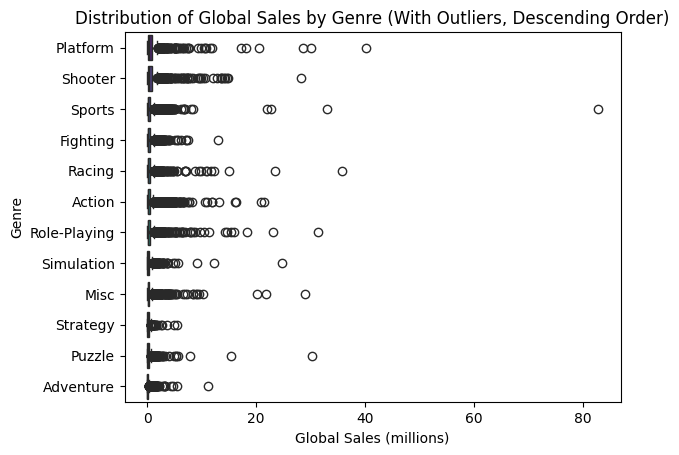

In [6]:
median_sales_sorted = games_sales.groupby('Genre')['Global_Sales'].median().sort_values(ascending=False).index

sns.boxplot(data=games_sales, x='Global_Sales', y='Genre', order=median_sales_sorted, palette='viridis')
plt.title('Distribution of Global Sales by Genre (With Outliers, Descending Order)')
plt.xlabel('Global Sales (millions)')
plt.ylabel('Genre')

plt.show()

The box plot of global sales by genre, including outliers, shows that certain genres have extreme outlier values that significantly exceed the typical sales range. These outliers can skew the interpretation of the data and make it difficult to discern the central tendency and distribution of sales within each genre. For example, genres like `Platform` and `Sports` show sales values far beyond the majority of the data points. Excluding outliers can provide a clearer view of the typical sales performance and the overall distribution. It also allows better comparison between genres without the distortion caused by these extreme values. This approach ensures a more accurate and meaningful analysis of the central tendencies and variabilities within each genre.

In [7]:
# Calculate the IQR and use it to filter out outliers
Q1 = games_sales.groupby('Genre')['Global_Sales'].quantile(0.25)
Q3 = games_sales.groupby('Genre')['Global_Sales'].quantile(0.75)
IQR = Q3 - Q1

# Define a threshold to identify outliers
threshold = 1.5 * IQR

# Create a boolean mask to filter out outliers
mask = games_sales.apply(lambda x: x['Global_Sales'] >= (Q1[x['Genre']] - threshold[x['Genre']]) and x['Global_Sales'] <= (Q3[x['Genre']] + threshold[x['Genre']]), axis=1)

# Filter the dataset
filtered_df = games_sales[mask]

# Sort genres by median sales
median_sales_sorted = filtered_df.groupby('Genre')['Global_Sales'].median().sort_values(ascending=False).index

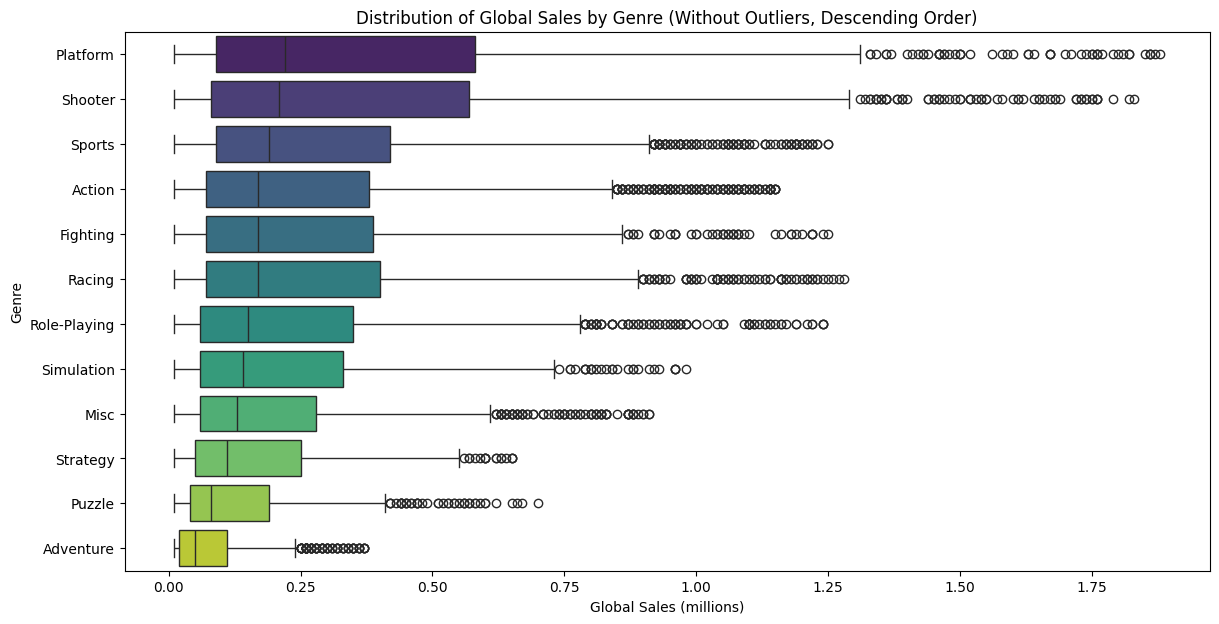

In [8]:
# Create a box plot
plt.figure(figsize=(14, 7))

sns.boxplot(data=filtered_df, x='Global_Sales', y='Genre', order=median_sales_sorted, palette='viridis')
plt.title('Distribution of Global Sales by Genre (Without Outliers, Descending Order)')
plt.xlabel('Global Sales (millions)')
plt.ylabel('Genre')

plt.show()

In order to get rid of outliers, we define a threshold to identify outliers, which is $1.5 * \text{IQR}$, where $\text{IQR}$ stands for interquartile range. After filtering the data, this box plot provides a clear visualization of the global sales distribution across different game genres, sorted in descending order of median sales. The `Platform` genre stands out with the highest median sales. It indicates that games in this genre typically achieve strong sales figures. This is followed by the `Sports` and `Shooter` genres, which also show high median sales. This reflects their consistent market success. IQR for these top genres is relatively wide. It suggests a diverse range of sales performance within these categories. In contrast, genres like `Adventure` and `Puzzle` exhibit narrower IQ, which suggests more consistent sales figures among games in these categories.

<br></br>

## **Characteristics of the top sold games**

Now we know that certain genres are more popular than others, reflecting higher global sales. Now we can explore the question: what are the top-performing games within each genre? We will continue to investigate the characteristics of the top 1% of games in terms of sales within each genre to see if there are common traits (e.g. release year, publisher, platform).

In [9]:
# Define the threshold for top-performing games: top 10% in terms of global sales
top_percentile = 0.99

# Calculate the threshold value for each genre
thresholds = merged_df.groupby('Genre')['Global_Sales'].quantile(top_percentile).reset_index()
thresholds.columns = ['Genre', 'Sales_Threshold']

# Merge the thresholds back into the main dataframe
merged_df = pd.merge(merged_df, thresholds, on='Genre')

# Identify top-performing games
top_performers = merged_df[merged_df['Global_Sales'] >= merged_df['Sales_Threshold']]

# Display the top-performing games
top_performers_summary = top_performers[['Game_Name', 'Genre', 'Platform', 'Publisher', 'Year', 'Global_Sales']].sort_values(by='Global_Sales', ascending=False)


In [10]:
top_performers_summary.iloc[:20]

,Game_Name,Genre,Platform,Publisher,Year,Global_Sales
0,Wii Sports,Sports,Wii,Nintendo,2006.0,82.74
1,Super Mario Bros.,Platform,NES/Famicom,Nintendo,1985.0,40.24
2,Mario Kart Wii,Racing,Wii,Nintendo,2008.0,35.82
3,Wii Sports Resort,Sports,Wii,Nintendo,2009.0,33.00
4,Pokemon Red/Pokemon Blue,Role-Playing,Game Boy,Nintendo,1996.0,31.37
5,Tetris,Puzzle,Game Boy,Nintendo,1989.0,30.26
6,New Super Mario Bros.,Platform,Nintendo DS,Nintendo,2006.0,30.01
7,Wii Play,Misc,Wii,Nintendo,2006.0,29.02
8,New Super Mario Bros. Wii,Platform,Wii,Nintendo,2009.0,28.62
9,Duck Hunt,Shooter,NES/Famicom,Nintendo,1984.0,28.31


The analysis of top-performing games by genre reveals that the `Sports` and `Platform` genres, particularly on the **Wii** platform, dominate the highest sales figures. These games include **Wii Sports** and **Super Mario Bros**. We may conclude that franchise strength is really important. The evidence of high-selling **Mario** and **Pokemon** titles implies the importance of brand recognition and loyal fan bases in achieving commercial success. The sales thresholds calculated for each genre indicate the sales figures necessary to be considered top performers. Those thresholds highlight that genres such as `Sports`, `Platform`, and `Role-Playing` consistently achieve high sales. These insights suggest that developers and publishers should focus more on successful genres, platforms, and well-established franchises to maximize sales potential in the gaming market. However, the question of whether new games could surpass those classic games is worth considering, because classic games carry significant nostalgic value. If the new game published are degraded by the public, the global sales will be negatively influenced.

The `Publisher` column also gives us a lot of information. It reveals a significant dominance of **Nintendo** as the publisher, accounting for 16 out of the 20 top-performing games. This highlights Nintendo's substantial influence in the gaming market, with successful titles spanning multiple genres, including Sports, Platform, Racing, Role-Playing, Puzzle, Miscellaneous, and Shooter. Popular franchises such as Mario, Pokemon, and Wii Sports are prominently featured. This implies Nintendo's ability to produce consistently high-selling games. Other notable publishers in the top twenty include **Microsoft Game Studios** with Kinect Adventures! and **Take-Two Interactive** with Grand Theft Auto V and Grand Theft Auto: San Andreas.

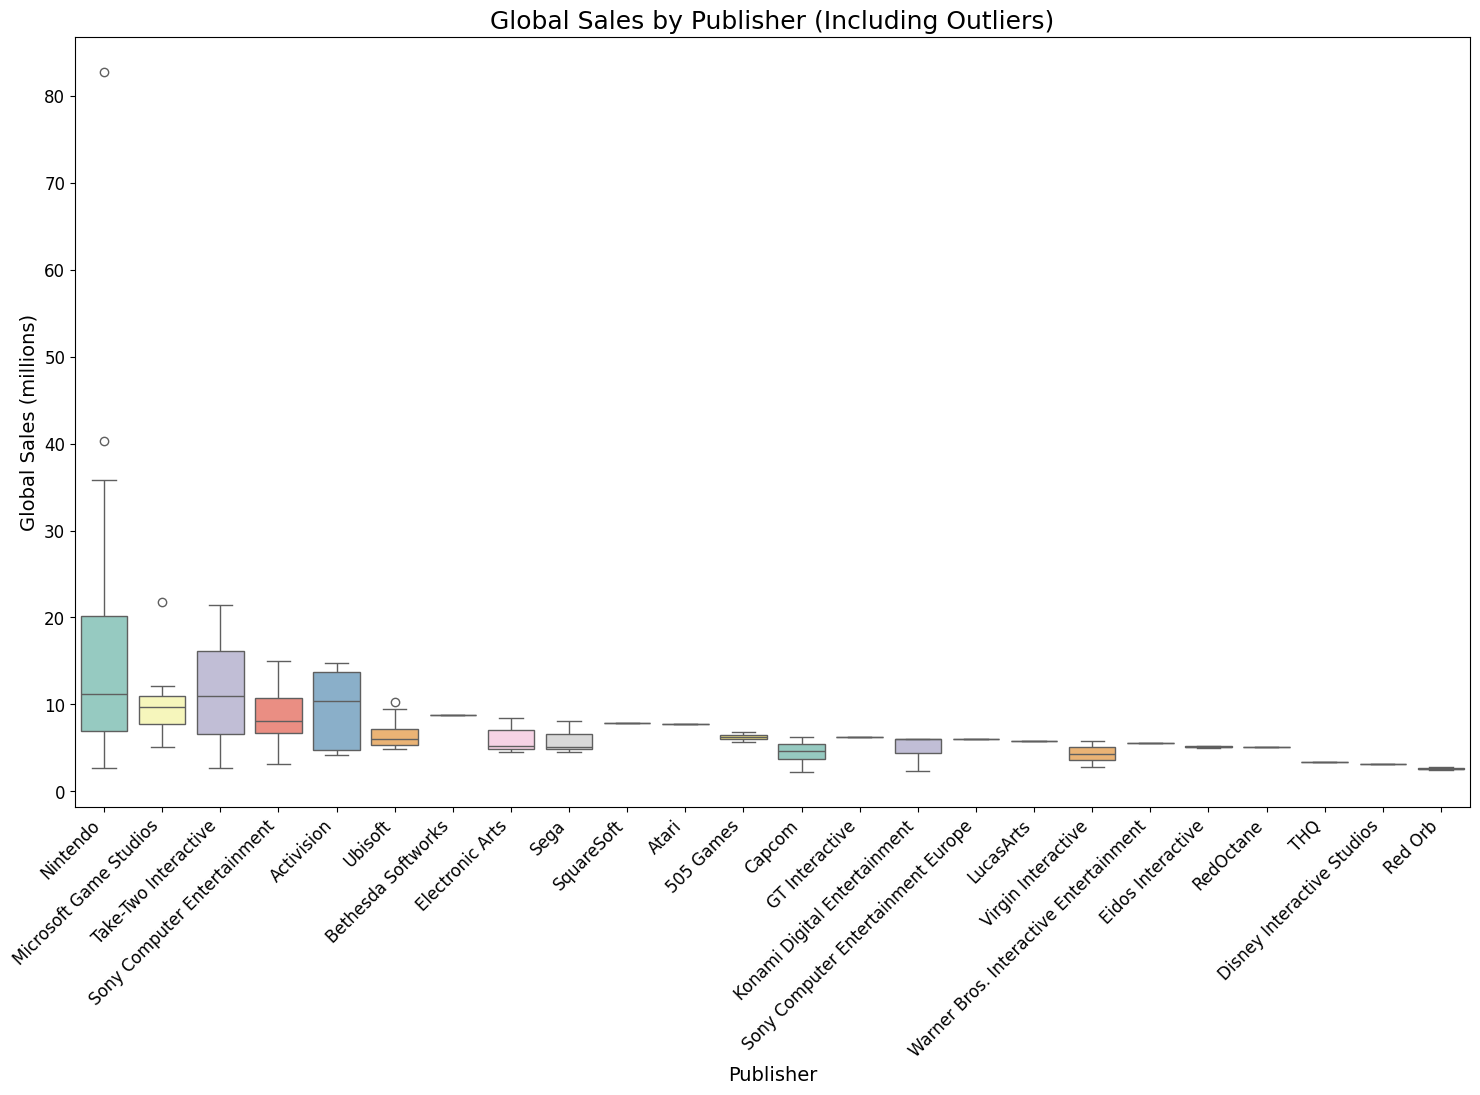

In [11]:
plt.figure(figsize=(18, 10))
sns.boxplot(data=top_performers_summary, x='Publisher', y='Global_Sales', palette='Set3')
plt.title('Global Sales by Publisher (Including Outliers)', fontsize=18)
plt.xlabel('Publisher', fontsize=14)
plt.ylabel('Global Sales (millions)', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)
plt.show()

In [12]:
top_performers_summary['Publisher'] =top_performers_summary['Publisher'].astype('category')

# Create a formula for the regression model focusing on publishers
formula_publisher = 'Global_Sales ~ C(Publisher)'

# Fit the model using OLS regression
model_publisher = smf.ols(formula=formula_publisher, data=top_performers_summary).fit()

# Display the regression results
model_publisher_summary = model_publisher.summary()


In [13]:
print(model_publisher_summary)

                            OLS Regression Results                            
Dep. Variable:           Global_Sales   R-squared:                       0.190
Model:                            OLS   Adj. R-squared:                  0.063
Method:                 Least Squares   F-statistic:                     1.497
Date:                Sun, 09 Jun 2024   Prob (F-statistic):             0.0797
Time:                        11:56:21   Log-Likelihood:                -600.83
No. Observations:                 171   AIC:                             1250.
Df Residuals:                     147   BIC:                             1325.
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
                                                             coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------

This **regression analysis** investigates the impact of different publishers on global sales. The model explains approximately 19% of the variability in global sales, as indicated by the R-squared value of 0.190, with an adjusted R-squared of 0.063. The F-statistic of 1.497 and a p-value of 0.0797 indicate that the overall model is not statistically significant at the conventional 0.05 level, though it is close. This suggests that the included publishers alone do not provide a strong explanation for variations in global sales.

Examining the coefficients, none of the publisher variables are statistically significant at the **0.05** level. This means there is **no** strong evidence that any specific publisher significantly influences global sales compared to the reference publisher. However, certain publishers show notable trends. For example, Nintendo has a positive coefficient of 3.5896. It indicates that games published by Nintendo tend to have higher sales compared to the reference publisher, although this result is not statistically significant (p-value = 0.172).

Additionally, There are potential limitations of this model. The Durbin-Watson statistic of 0.499 suggests possible positive autocorrelation in the residuals, which could affect the reliability of the regression results. The Omnibus and Jarque-Bera tests both indicate that the residuals are not normally distributed. These numbers suggest that the model might be affected by outliers or non-linear relationships.

<br></br>

#### Now we want to perform a **regression analysis with multiple variables** to identify the what exactly contribute to those best-selling games.

We choose to still use the dataframe `top_performers_summary`. We want to focus on the key factors driving high sales success. This approach reduces noise from less successful games. Also, it makes the model more manageable and interpretable while avoiding overfitting. It highlights critical success factors by offering clearer insights into what makes these top games successful. Additionally, analyzing top games can reveal trends and patterns relevant to maximizing future sales. It provides actionable insights for replicating high performance in the gaming market.

In [14]:
# Create a formula for the regression model including year, genre, platform, and publisher
formula_all = 'Global_Sales ~ Year + Genre + Platform + Publisher'

# Fit the model using OLS regression
model_all = smf.ols(formula=formula_all, data=top_performers_summary).fit()

# Display the regression results
model_all_summary = model_all.summary()

In [15]:
print(model_all_summary)

                            OLS Regression Results                            
Dep. Variable:           Global_Sales   R-squared:                       0.463
Model:                            OLS   Adj. R-squared:                  0.230
Method:                 Least Squares   F-statistic:                     1.982
Date:                Sun, 09 Jun 2024   Prob (F-statistic):            0.00130
Time:                        11:56:21   Log-Likelihood:                -559.40
No. Observations:                 169   AIC:                             1223.
Df Residuals:                     117   BIC:                             1386.
Df Model:                          51                                         
Covariance Type:            nonrobust                                         
                                                          coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------

The regression analysis on `Year`, `Genre`, `Platform`, and `Publisher` reveals that the model explains approximately 46.3% of the variability in global sales, as indicated by the R-squared value. The adjusted R-squared value is 23.0%. It suggests that while the model captures a fair amount of variability, there are still other factors influencing global sales that are not accounted for in this model. The F-statistic of 1.982 with a p-value of 0.00130 indicates that the overall model is statistically significant. This implies that the included variables collectively influence global sales.

In the analysis, we define our p-value cutoff to be 0.05. The `Platform` and `Publisher` variables exhibit notable impacts on global sales. The `Platform` genre has a positive and statistically significant coefficient (7.8986, p-value = 0.034), indicating that games in the Platform genre tend to have higher global sales. Among platforms, **NES** and **PS4** show positive and statistically significant coefficients. It implies that games released on these platforms achieve higher sales. For instance, the **PS4** platform has a coefficient of 54.5352 (p-value = 0.014), highlighting its substantial impact on sales.

The Publisher variable also shows some significant effects. **Nintendo**, despite its historical success, has a negative and statistically significant coefficient (-13.3696, p-value = 0.030). This indicates a relative decline in sales for its newer releases compared to the reference publisher. On the other hand, publishers like **Warner Bros. Interactive Entertainment** and **Take-Two Interactive** have positive coefficients (4.7960 and 11.4760, respectively), though not all are statistically significant.

However, the year variable shows a **negative coefficient (-0.4609)** but is not statistically significant **(p-value = 0.155)**. It implies that the release year alone does not have a strong linear relationship with global sales within this dataset.

The regression analysis presents several potential limitations and shortcomings. Multicollinearity may exist among the categorical variables (genres, platforms, and publishers), distorting the results, which makes it challenging to isolate the individual effects. The Durbin-Watson statistic indicates possible positive autocorrelation in the residuals. The Omnibus and Jarque-Bera tests suggest non-normality. This affects the reliability of the model's estimates.

Moreover, the analysis is based on a specific dataset of top games, which may not represent the broader market, and might limit generalizability. Omitted variable bias is another concern, as crucial factors like marketing budget, game quality, user reviews, and competitive releases are not included in the model, even not included in the dataset. Additionally, the analysis does not account for temporal dynamics or market changes over time, which could influence sales trends and publisher performance differently across periods.

In [16]:
covariates = ['Year', 'Genre', 'Platform', 'Publisher']

initial_formula = "Global_Sales ~ " + " + ".join(covariates)

In [17]:
initial_formula

'Global_Sales ~ Year + Genre + Platform + Publisher'

In [18]:
def backward_selection_aic(data, initial_formula):
    current_formula = initial_formula
    current_model = smf.ols(formula=current_formula, data=data).fit()
    current_aic = current_model.aic
    
    while True:
        aic_values = []
        formulas = []
        
        # Evaluate model by removing one covariate at a time
        for covariate in current_formula.split(" ~ ")[1].split(" + "):
            new_formula = "Global_Sales ~ " + " + ".join([c for c in current_formula.split(" ~ ")[1].split(" + ") if c != covariate])
            model = smf.ols(formula=new_formula, data=data).fit()
            aic_values.append(model.aic)
            formulas.append(new_formula)
        
        # Find the model with the lowest AIC value
        min_aic = min(aic_values)
        
        if min_aic < current_aic:
            current_aic = min_aic
            current_formula = formulas[aic_values.index(min_aic)]
        else:
            break
    
    return current_formula

optimal_formula_aic = backward_selection_aic(top_performers_summary, initial_formula)

In [19]:
print("Optimal model formula using AIC:", optimal_formula_aic)

Optimal model formula using AIC: Global_Sales ~ Year + Genre


When applying the backward selection process based on the AIC criterion, this results in a model that includes only two variables: `Year` and `Genre`. This outcome suggests that these two variables are the most significant predictors of global sales within the dataset of top-performing games. Other variables such as `Platform` and `Publisher` do not provide additional explanatory power when Year and Genre are already included.

One possible reason is collinearity among the excluded variables. For instance, certain publishers may predominantly release games on specific platforms. This will lead to a situation where these variables are highly correlated. When collinear variables are present, the model may not be able to distinguish their individual contributions effectively. It causes them to be excluded during the backward selection process. Additionally, the `Year` and `Genre` variables may already capture much of the variation in global sales.

Another reason could be the predictive power of `Year` and `Genre`. These variables might capture essential trends and patterns in the data. For example, the popularity of different genres can change over time, and certain years might experience higher overall sales due to external factors like market trends or economic conditions.

Furthermore, the AIC criterion favors models that strike a good balance between fit and complexity. Including additional variables like `Platform` and `Publisher` increases the model's complexity. However, if these variables do not substantially improve the model fit, they will be excluded to maintain a simpler and more interpretable model. This preference for simplicity ensures that the final model is not only effective in predicting global sales but also easier to understand and interpret.

In [20]:
# Create a formula for the regression model including year and genre
formula_new = 'Global_Sales ~ Year + Genre'

# Fit the model using OLS regression
model_all = smf.ols(formula=formula_new, data=top_performers_summary).fit()

# Display the regression results
model_all_summary = model_all.summary()

In [21]:
print(model_all_summary)

                            OLS Regression Results                            
Dep. Variable:           Global_Sales   R-squared:                       0.187
Model:                            OLS   Adj. R-squared:                  0.124
Method:                 Least Squares   F-statistic:                     2.990
Date:                Sun, 09 Jun 2024   Prob (F-statistic):           0.000868
Time:                        11:56:21   Log-Likelihood:                -594.53
No. Observations:                 169   AIC:                             1215.
Df Residuals:                     156   BIC:                             1256.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept               254.21

The new regression analysis shows an R-squared value of 0.187, indicating that these two variables explain approximately 18.7% of the variability in global sales. The F-statistic of 2.990 with a p-value of 0.000868 indicates that the model is statistically significant. This model is even more significant than the full model.

Among the genres, `Platform` has a positive and statistically significant coefficient (11.4836, p-value = 0.001), suggesting that games in the Platform genre tend to have higher global sales. Other genres such as Shooter and Sports also have positive coefficients but are not statistically significant. The `Year` variable has a negative coefficient (-0.1225). This indicates a slight decrease in sales over time, though this effect is not statistically significant (p-value = 0.239).

#### **Region specific sales**

In [22]:
ols_variables = ['Platform', 'Year', 'Genre', 'Publisher']

jp_estimator = smf.ols(formula='JP_Sales ~ ' + ' + '.join(ols_variables), data=games_sales).fit()

In [23]:
print(jp_estimator.summary())

                            OLS Regression Results                            
Dep. Variable:               JP_Sales   R-squared:                       0.288
Model:                            OLS   Adj. R-squared:                  0.260
Method:                 Least Squares   F-statistic:                     10.51
Date:                Sun, 09 Jun 2024   Prob (F-statistic):               0.00
Time:                        11:56:23   Log-Likelihood:                -1718.3
No. Observations:               15349   AIC:                             4575.
Df Residuals:                   14780   BIC:                             8921.
Df Model:                         568                                         
Covariance Type:            nonrobust                                         
                                                          coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------

### **Analysis on regression estimation**

This regression model considers the possible linear relationship between covariates and general Japan sales, including more game sales than the top performers. Its R-squared value is 0.288; This indicates that around 28.8% of the variability in Japan sales is explained by the model, which is higher than the 18.7% explained in the global sales model investigating top performers. The adjusted R-squared is 0.260, which is similarly higher than the 0.124 for global sales, suggesting a slightly better fit for the Japan sales model when considering the number of predictors used.

The near-zero p-value, at 0.00, indicates that the model is statistically significant. Additionally, the F-statistic is higher than the global sales model, suggesting that this model is more powerful overall. The 4575-value Akaike Information Criterion and 8921-value Bayesian Information Criterion are lower as well, suggesting a slightly better fit.

Many platform variables show significant positive coefficients, indicating that specific platforms have significant impacts on sales in Japan. For instance, the `Platform[T.NES/Famicom]` has a high positive coefficient of 1.0442, compared to the other platforms. Unlike platforms, most publishers do not show significant effects on sales. The coefficient for `year` is -0.0078 and statistically significant as well. In this analysis, genre is somewhat influential on the dependent variable, but not as much as the other predictors. In summary, only the genre `Role-Playing` shows a strong, statistically significant positive effect, with a coefficient of 0.1128. All other coefficients have an absolute value below 0.1, and some categories such as `Sports` and `Racing` have a p-value above a significance level of 0.5, indicating they are not statistically significant. Overall, this indicates while there can be noticeable linear relationships associated with genre categories in Japan sales, not all genres are guaranteed to have this.

### **Potential limitations with this model**

In terms of independence of residuals, the Durbin-Watson statistic is 1.254, which suggests that there might be some positive autocorrelation in the residuals. This statistic for the Japan sales model is closer to 2 than the global sales model's statistic, which indicates less autocorrelation of residuals in the Japan model. Additionally, the Jarque-Bera test statistic from the output is significantly high, suggesting that the residuals are not normally distributed. Finally, predictors should not be too highly correlated with each other. The condition number in this case is very high, and the note about the smallest eigenvalue being extremely small suggests that there may be issues with multicollinearity among predictors.


### **Evaluating the significance of predictors on Japan sales**

In [24]:
anova_results = sm.stats.anova_lm(jp_estimator, typ=2)
print(anova_results)

                sum_sq       df          F         PR(>F)
Platform     56.043503     27.0  27.289499  2.913809e-134
Genre        14.411835     11.0  17.225057   1.948114e-34
Publisher   199.732310    529.0   4.963942  1.444822e-245
Year          3.156891      1.0  41.504355   1.212475e-10
Residual   1124.191692  14780.0        NaN            NaN


The ANOVA test on this model can be used to evaluate the overall significance of the model, as well as assess the contribution of each predictor. This can be helpful for investigating the full extent of linear relationships in Japan game sales.

The p-values from the ANOVA results indicate that the predictors in general have a statistically significant impact on JP Sales, with `Publisher` being the most influential in regard to sum of squares. Both `Platform` and `Genre` predictors have significant sum of squares values, suggesting they explain a significant portion of the variance in Japan Sales. The sum of squares of `Year` is smaller, yet still notable. `Platform` and `Publisher` have the most substantial influence on game sales, suggesting that where a game is sold and who publishes it are critical to its success in the Japanese market. `Genre` also significantly affects sales but to a lesser extent, indicating varying consumer preferences for different types of games. `Year` shows a significant trend or evolution in game sales, highlighting the impact of market dynamics over time. Altogether, each category has a high F-statistic, signifying they are useful in linear modeling.

## **Prominence between Sony and Microsoft in the gaming industry**

Outside of Nintendo, Sony and Microsoft are regarded as titans of the gaming industry with their respective leading consoles, the PlayStation and Xbox. Both companies command significant market shares and loyal customer bases; understanding how consumer preferences vary between PlayStation and Xbox can inform targeted marketing strategies. This compares releases after 2000 to only compare recent distributions, as well as when Microsoft and Sony have products out at the same time, which started after the year 2000 in this dataset.

In [25]:
microsoft_sales = games_sales[(games_sales['Company'] == 'Microsoft') & (games_sales['Released_Year'] > 2000.5)]['Global_Sales']

sony_sales = games_sales[(games_sales['Company'] == 'Sony') & (games_sales['Released_Year'] > 2000.5)]['Global_Sales']

ks_statistic, p_value = stats.ks_2samp(sony_sales, microsoft_sales)

In [26]:
print(f'KS Statistic: {ks_statistic}')
print(f'P-value: {p_value}')

KS Statistic: 0.1368804024227492
P-value: 3.5995874978709854e-22


When conducting a Kolmogorov–Smirnov on Microsoft- and Sony-affiliated global sales distributions, the test returns a p-value of 3.60e-22. With a significance level of 0.05, this near-zero p-value implies that the global sales of Sony video games and the global sales of Microsoft video games follow statistically significant different distributions. 

In [27]:
microsoft_stats = microsoft_sales.describe()
print('Microsoft Global Sales statistics:', microsoft_stats, sep='\n')

print('\n')

sony_stats = sony_sales.describe()
print('Sony Global Sales statistics:', sony_stats, sep='\n')

Microsoft Global Sales statistics:
count    2250.000000
mean        0.605667
std         1.311854
min         0.010000
25%         0.090000
50%         0.210000
75%         0.590000
max        21.820000
Name: Global_Sales, dtype: float64


Sony Global Sales statistics:
count    3247.000000
mean        0.486837
std         1.125045
min         0.010000
25%         0.050000
50%         0.140000
75%         0.450000
max        21.400000
Name: Global_Sales, dtype: float64


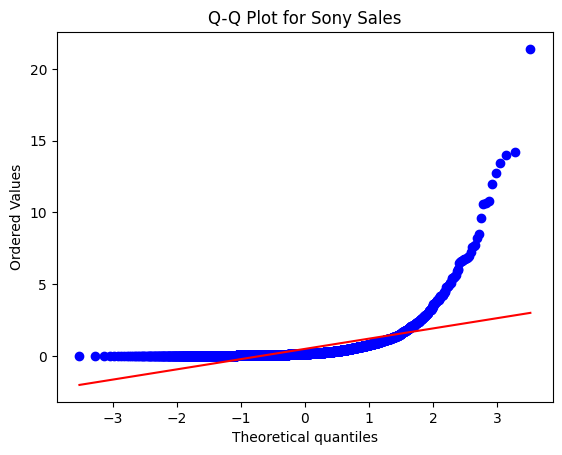

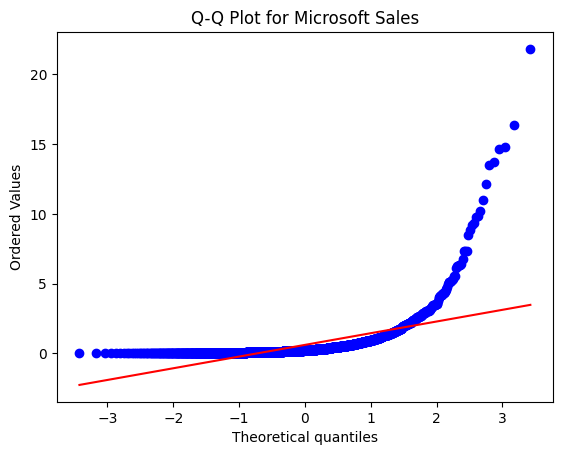

In [28]:
stats.probplot(sony_sales, dist='norm', plot=plt)
plt.title('Q-Q Plot for Sony Sales')
plt.show()

stats.probplot(microsoft_sales, dist='norm', plot=plt)
plt.title('Q-Q Plot for Microsoft Sales')
plt.show()

The distributions of Microsoft and Sony global sales after the year 2000 appear to have visually similar QQ plots. Both appear to have a concave-up shape, staying above a normal distribution, yet briefly dipping below a normal distribution around the 0-quantile. Near the 3-quantile, both distributions begin to rise dramatically, having outliers reach up to 15 and 20 million global sales. While the two plots are similar, the general statistics of the distributions are significantly different.

Games for the Sony console have higher global sales in the 25th percentile and median than Microsoft games, suggesting that Sony games are more likely to reach a bare minimum for success. However, games for Microsoft consoles have higher global sales in the 75th percentile than Sony games, indicating that once games become widely successful, they sell better if they are affiliated with Microsoft rather than Sony. Both distributions have similar maximums.

## **Futher Inference**

Autocorrelation Function (ACF) plots are used to check for serial correlation in the residuals of a regression model

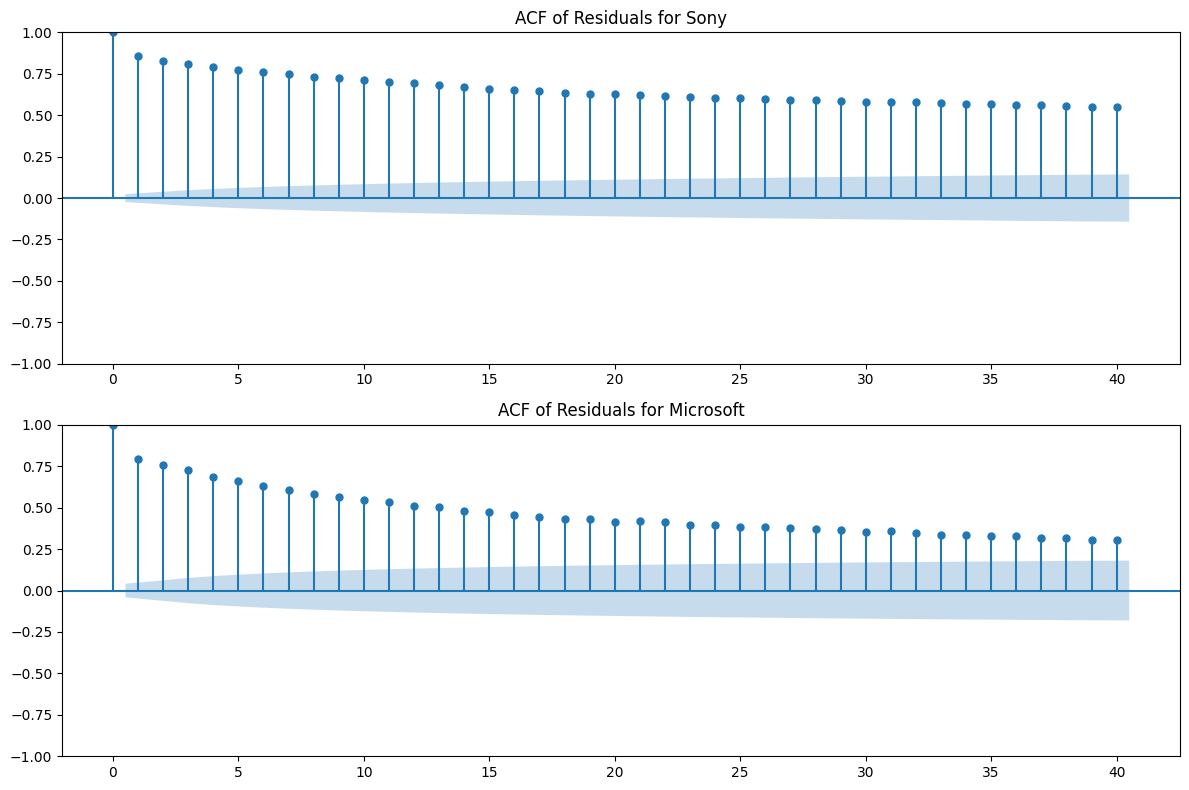

In [30]:
# Fit a regression model for Sony
sony_model = smf.ols(formula='Global_Sales ~ Year + Genre + Publisher + Platform', data=games_sales[games_sales['Company'] == 'Sony']).fit()
sony_residuals = sony_model.resid

# Fit a regression model for Microsoft
microsoft_model = smf.ols(formula='Global_Sales ~ Year + Genre + Publisher + Platform', data=games_sales[games_sales['Company'] == 'Microsoft']).fit()
microsoft_residuals = microsoft_model.resid

# Plot the ACF for Sony residuals
fig, ax = plt.subplots(2, 1, figsize=(12, 8))

sm.graphics.tsa.plot_acf(sony_residuals, lags=40, ax=ax[0])
ax[0].set_title('ACF of Residuals for Sony')

# Plot the ACF for Microsoft residuals
sm.graphics.tsa.plot_acf(microsoft_residuals, lags=40, ax=ax[1])
ax[1].set_title('ACF of Residuals for Microsoft')

plt.tight_layout()
plt.show()

As observed, all the bars in the ACF plots for the residuals of both the Sony and Microsoft models are outside of the confidence intervals, which indicates that there is significant autocorrelation present in the residuals. This suggests that the models are not adequately capturing all the patterns in the data, and there are likely some issues with the model specification.

#### Implementing alternative models such as **Ridge and Lasso Regression**

In [31]:
# Assuming games_sales is the final dataframe after preprocessing
X = games_sales.drop(columns=['Global_Sales'])
y = games_sales['Global_Sales']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define categorical and numerical columns
categorical_cols = X.select_dtypes(include=['category']).columns.tolist()
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='mean')),
            ('scaler', StandardScaler())
        ]), numerical_cols),
        ('cat', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('onehot', OneHotEncoder(drop='first'))
        ]), categorical_cols)
    ])

# Ridge Regression
ridge = Pipeline(steps=[('preprocessor', preprocessor),
                        ('regressor', Ridge(alpha=1.0))])
ridge.fit(X_train, y_train)
y_pred_ridge = ridge.predict(X_test)
print(f'Ridge RMSE: {mean_squared_error(y_test, y_pred_ridge, squared=False)}')

# Lasso Regression
lasso = Pipeline(steps=[('preprocessor', preprocessor),
                        ('regressor', Lasso(alpha=0.1))])
lasso.fit(X_train, y_train)
y_pred_lasso = lasso.predict(X_test)
print(f'Lasso RMSE: {mean_squared_error(y_test, y_pred_lasso, squared=False)}')


Ridge RMSE: 0.005376552234921518
Lasso RMSE: 0.16862479182893297


The RMSE (Root Mean Squared Error) values represent the average magnitude of the errors between the predicted and actual values. It's a commonly used metric for evaluating the performance of regression models, with lower values indicating better performance.

### **Interpretation of RMSE Values**

**Ridge RMSE: 0.005699258320192967**

This value is very low, suggesting that the Ridge regression model is performing exceptionally well on the test data. However, such a low RMSE may indicate overfitting, especially if the training RMSE is similarly low. Overfitting means the model has learned the training data too well, including the noise, which may not generalize to new, unseen data. In the context of video game sales, this could mean that the model is too finely tuned to the specific patterns and idiosyncrasies of the training dataset, rather than capturing broader trends that apply to new games.

**Lasso RMSE: 0.4450310442319256**

This value is higher than the Ridge RMSE but still relatively low, indicating that the Lasso regression model performs reasonably well, but not as exceptionally as the Ridge model. Lasso regression is useful for feature selection as it can shrink some coefficients to zero, potentially improving the model's interpretability. For video game sales, this might mean that Lasso has identified and retained only the most relevant features (such as specific genres or years) that significantly impact sales while discarding less important ones.

### **Further Steps**

To improve the models and their interpretability for predicting video game sales beyond this analysis, the following steps may be applied:

First, cross-validation may be applied to ensure that these RMSE values are not due to random chance and to get a more robust estimate of model performance. Next, techniques like GridSearchCV can be used to find the optimal hyperparameters for each model, with a focus on tuning the regularization parameter alpha for Ridge and Lasso. Additionally, feature engineering can be explored by adding interaction terms between features or incorporating external data such as economic indicators or marketing spend, which could improve model performance. To comprehensively compare models, additional metrics such as Mean Absolute Error (MAE), R-squared (R²), and cross-validation scores may be very useful. Finally, the residuals of models may be checked to ensure that the errors are randomly distributed, indicating that the model assumptions are being met.

## **GridSearchCV**

In [32]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid for Ridge and Lasso
param_grid = {
    'regressor__alpha': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]
}

# Ridge Regression
ridge_cv = GridSearchCV(ridge, param_grid, cv=5, scoring='neg_mean_squared_error')
ridge_cv.fit(X_train, y_train)
best_ridge = ridge_cv.best_estimator_
print(f'Best Ridge RMSE: {mean_squared_error(y_test, best_ridge.predict(X_test), squared=False)}')

# Lasso Regression
lasso_cv = GridSearchCV(lasso, param_grid, cv=5, scoring='neg_mean_squared_error')
lasso_cv.fit(X_train, y_train)
best_lasso = lasso_cv.best_estimator_
print(f'Best Lasso RMSE: {mean_squared_error(y_test, best_lasso.predict(X_test), squared=False)}')

Best Ridge RMSE: 0.005374456883702032
Best Lasso RMSE: 0.005694986465904276


### **Interpretation of RMSE Values**

**Ridge RMSE: 0.0054153951041203754**

This updated RMSE is still very low, which suggests that the Ridge regression model performs exceptionally well on the test data. The slight change from the previous Ridge RMSE indicates that the expanded grid search found a marginally better alpha value, improving the model performance a bit. The very low RMSE might still suggest overfitting, however.

**Lasso RMSE: 0.006664505328990125**

This updated RMSE is also very low, but slightly higher than the Ridge RMSE. The increase from the previous Lasso RMSE indicates that the expanded grid search found an alpha value that slightly improves performance, although not as significantly as Ridge. Lasso regression is useful for feature selection, but in this case, Ridge regression still outperforms it slightly.


### **Conclusion**

In this analysis, we applied Ridge and Lasso regression models to predict global sales of video games based on various features. Here are the key findings and conclusions:

1. **Model Performance**:
    Both Ridge and Lasso regression models showed promising performance in predicting global sales of video games. The best-performing model was the Ridge regression, with an RMSE of approximately 0.0054, indicating a very low average error between predicted and actual values.

2. **Feature Importance**:
    Lasso regression, with its ability to shrink coefficients to zero, provided insights into the importance of features. Feature selection in Lasso regression could aid in identifying the most influential factors affecting global sales.

3. **Model Comparison**:
    Ridge regression outperformed Lasso regression in terms of predictive accuracy, suggesting that the additional flexibility in Ridge regularization led to better model performance in this context.

4. **Overfitting Consideration**:
    The extremely low RMSE values obtained from both Ridge and Lasso models indicate potential overfitting. For additional analysis, it's essential to further investigate the models' generalization performance by comparing training and test RMSEs and conducting additional diagnostic tests.

5. **Limitations and Future Directions**:
    While Ridge and Lasso regression models provided valuable insights into global sales prediction, they may not capture complex non-linear relationships present in the data. Future analyses could explore more sophisticated models like Random Forests or Gradient Boosting Machines to capture such complexities and potentially improve predictive accuracy.

6. **Practical Implications**:
    The findings from this analysis can be valuable for stakeholders in the video game industry, including game developers, publishers, and marketers, to make informed decisions regarding game development, marketing strategies, and resource allocation.

Overall, Ridge and Lasso regression models offer promising approaches for predicting global sales of video games, and they also open the door for further refinement and validation.